In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# AICellFate model with image data

In [1]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# load all confusion matrices

conf_matrix_cellfate_seed42 = np.sum((np.load('all_confusion_matrices_cellfate_6.npy'), np.load('all_confusion_matrices_cellfate_10.npy')), axis=0)
conf_matrix_cellfate_seed43 = np.sum((np.load('all_confusion_matrices_cellfate_seed43_3.npy'), np.load('all_confusion_matrices_cellfate_seed43_6.npy'), np.load('all_confusion_matrices_cellfate_seed43_10.npy')), axis=0)
conf_matrix_cellfate_seed44 = np.sum((np.load('all_confusion_matrices_cellfate_seed44_4.npy'), np.load('all_confusion_matrices_cellfate_seed44_10.npy')), axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [50]:
conf_matrix_cellfate[0,0][0,1]

0.34234234234234234

In [51]:
# calculate precisions

precision_cellfate = np.zeros((11, 3))
accuracy_cellfate = np.zeros((11, 3))
false_positives_cellfate = np.zeros((11, 3))
false_negatives_cellfate = np.zeros((11, 3))

for tp in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, tp]
        precision_cellfate[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [59]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

Plotting results of our model

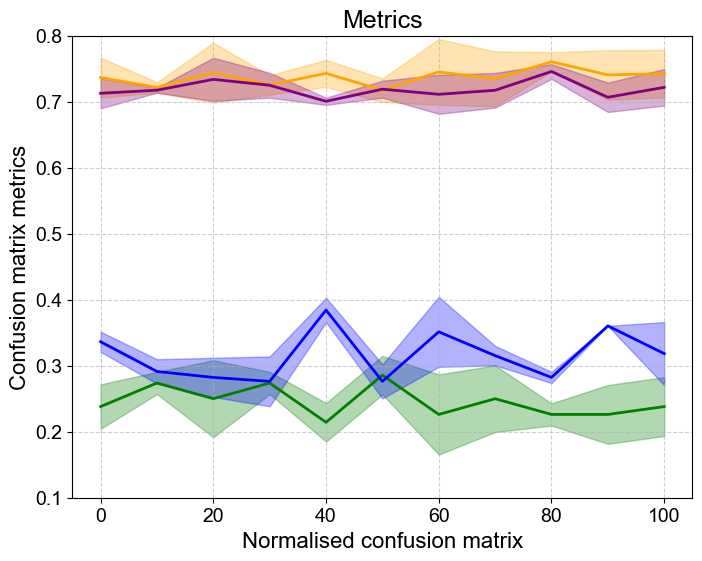

In [60]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(time_points, mean_precisions, color='orange', linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(time_points, mean_accuracies, color='purple', linewidth=2)
plt.fill_between(time_points, mean_accuracies - std_accuracies, 
                 mean_accuracies + std_accuracies, color='purple', alpha=0.3)

# False Positives (green)
plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
plt.fill_between(time_points, mean_false_positives - std_false_positives,
                 mean_false_positives + std_false_positives, color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
                    mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Normalised confusion matrix", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# MLP model with tabular data

In [ ]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# tabular_train = np.load('../data/tracks/time_norm_train_track.npy') ### THIS WASNT DONE CORRECTLY
# tabular_test = np.load('../data/tracks/time_norm_test_track.npy')
# train_labels = np.load("../data/labels/train_labels.npy")
# test_labels = np.load("../data/labels/test_labels.npy")

In [2]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [3]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

train_tracks_features = train_tracks[:, :, 4:17] 
test_tracks_features = test_tracks[:, :, 4:17]

In [8]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)
        
        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data

In [9]:
train_tracks_norm = normalize_cell_time(train_tracks_features)
test_tracks_norm = normalize_cell_time(test_tracks_features)

In [14]:
np.nonzero(train_tracks_norm[:,0] != train_tracks_features[:,0])

(array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,  15,
         15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  31,  31,
         31,  31,  31,  31,  31,  31,  31,  31,  31,  31, 310, 310, 310,
        310, 310, 310, 310, 310, 310, 310, 310, 310, 328, 328, 328, 328,
        328, 328, 328, 328, 328, 328, 328, 328, 342, 342, 342, 342, 342,
        342, 342, 342, 342, 342, 342, 342, 428, 428, 428, 428, 428, 428,
        428, 428, 428, 428, 428, 428, 471, 471, 471, 471, 471, 471, 471,
        471, 471, 471, 471, 471, 497, 497, 497, 497, 497, 497, 497, 497,
        497, 497, 497, 497, 624, 624, 624, 624, 624, 624, 624, 624, 624,
        624, 624, 624, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629,
        629, 629, 869, 869, 869, 869, 869, 869, 869, 869, 869, 869, 869,
        869, 915, 915, 915, 915, 915, 915, 915, 915, 915, 915, 915, 915,
        963, 963, 963, 963, 963, 963, 963, 963, 963, 963, 963, 963, 966,
        966, 966, 966, 966, 966, 966, 966, 966, 966

In [174]:
# find how many cells are zero 

for cell in range(train_tracks_norm.shape[0]):
    if np.all(train_tracks_norm[cell] == 0):
        print(cell)

1
15
31
310
328
342
428
471
497
624
629
869
915
963
966


In [186]:
# Remove all cells that are all zeros across all timepoints and features
train_tracks_norm_filtered = train_tracks_norm[~(np.all(train_tracks_norm == 0, axis=(1, 2)))]
test_tracks_norm_filtered = test_tracks_norm[~(np.all(test_tracks_norm == 0, axis=(1, 2)))]

In [ ]:
conf_matrix_tabular = np.zeros((3, 11, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

for seed in [42, 43, 44]:
    for i in range(train_tracks_norm.shape[1]): #tabular_train.shape[1]
        frame = i
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))].flatten()), y=train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))].flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)
        np.random.seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_norm_filtered[:,frame,:].shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_norm[~(np.all(test_tracks_norm == 0, axis=(1, 2)))][:,frame,:], test_labels[~(np.all(test_tracks_norm == 0, axis=(1, 2)))], test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_norm_filtered[:,frame,:], train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))], batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))]))
        threshold = 0.5
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        conf_matrix_tabular[seed-42, i] = conf_matrix_normalized
        

        # all_confusion_matrices[i] = conf_matrix_normalized

        # precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
        # mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        # print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

        # precisions[i] = precision
        # mean_diagonals[i] = mean_diagonal


Model: "sequential_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_222         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_888 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_666 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_889 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_667 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_890 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_668 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_891 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6348 - loss: 0.8280 - val_accuracy: 0.8235 - val_loss: 0.5817
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 0.7908 - val_accuracy: 0.8162 - val_loss: 0.6191
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5786 - loss: 0.7802 - val_accuracy: 0.5368 - val_loss: 0.6715
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.5940 - loss: 0.7524 - val_accuracy: 0.4779 - val_loss: 0.6943
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.5958 - loss: 0.7378 - val_accuracy: 0.5074 - val_loss: 0.7023
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.5697 - loss: 0.7261 - val_accuracy: 0.5074 - val_loss: 0.6946
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6131 - loss: 0.7160 - val_accuracy: 0.5441 - val_loss: 0.6760
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6046 - loss: 0.7393 - val_accuracy: 0.5441

Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_223         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_892 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_669 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_893 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_670 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_894 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_671 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_895 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6387 - loss: 0.8304 - val_accuracy: 0.8529 - val_loss: 0.5490
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6485 - loss: 0.7732 - val_accuracy: 0.8088 - val_loss: 0.6197
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.6388 - loss: 0.7383 - val_accuracy: 0.4779 - val_loss: 0.6806
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6301 - loss: 0.7497 - val_accuracy: 0.4632 - val_loss: 0.6975
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.6423 - loss: 0.7202 - val_accuracy: 0.4706 - val_loss: 0.7012
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.6997 - val_accuracy: 0.4853 - val_loss: 0.6863
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6500 - loss: 0.6902 - val_accuracy: 0.5368 - val_loss: 0.6604
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.6200 - loss: 0.6969 - val_accuracy: 0.5515 -

Model: "sequential_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_224         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_896 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_672 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_897 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_673 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_898 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_674 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_899 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6365 - loss: 0.8333 - val_accuracy: 0.8382 - val_loss: 0.5733
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 0.7713 - val_accuracy: 0.7794 - val_loss: 0.6076
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.6690 - loss: 0.7348 - val_accuracy: 0.5956 - val_loss: 0.6499
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.6498 - loss: 0.7346 - val_accuracy: 0.4853 - val_loss: 0.6684
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.6653 - loss: 0.7145 - val_accuracy: 0.4779 - val_loss: 0.6785
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6594 - loss: 0.6899 - val_accuracy: 0.4853 - val_loss: 0.6675
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6638 - loss: 0.6674 - val_accuracy: 0.5515 - val_loss: 0.6468
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.6282 - loss: 0.6768 - val_accuracy: 0.5368

Model: "sequential_225"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_225         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_900 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_675 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_901 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_676 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_902 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_677 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_903 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6445 - loss: 0.8419 - val_accuracy: 0.8456 - val_loss: 0.5460
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6461 - loss: 0.7693 - val_accuracy: 0.8088 - val_loss: 0.5866
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6389 - loss: 0.7612 - val_accuracy: 0.6029 - val_loss: 0.6336
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6388 - loss: 0.7376 - val_accuracy: 0.5662 - val_loss: 0.6558
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6377 - loss: 0.7241 - val_accuracy: 0.5662 - val_loss: 0.6678
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6645 - loss: 0.7150 - val_accuracy: 0.5809 - val_loss: 0.6573
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6588 - loss: 0.6967 - val_accuracy: 0.5882 - val_loss: 0.6413
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6361 - loss: 0.6911 - val_accuracy: 0.59

Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_226         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_678 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_679 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_680 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6383 - loss: 0.8256 - val_accuracy: 0.8088 - val_loss: 0.5683
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 0.7646 - val_accuracy: 0.8088 - val_loss: 0.5908
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6824 - loss: 0.7384 - val_accuracy: 0.6103 - val_loss: 0.6386
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6753 - loss: 0.7215 - val_accuracy: 0.5294 - val_loss: 0.6636
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6567 - loss: 0.6948 - val_accuracy: 0.5074 - val_loss: 0.6775
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.6623 - loss: 0.6983 - val_accuracy: 0.5882 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.6425 - loss: 0.6744 - val_accuracy: 0.5882 - val_loss: 0.6128
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6571 - loss: 0.6862 - val_accuracy: 0.5956

Model: "sequential_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_227         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_681 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_682 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_910 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_683 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6270 - loss: 0.8247 - val_accuracy: 0.8750 - val_loss: 0.5315
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6658 - loss: 0.7722 - val_accuracy: 0.8676 - val_loss: 0.5683
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.6693 - loss: 0.7433 - val_accuracy: 0.6397 - val_loss: 0.6294
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.6467 - loss: 0.7317 - val_accuracy: 0.5882 - val_loss: 0.6543
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6456 - loss: 0.7206 - val_accuracy: 0.5956 - val_loss: 0.6500
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6389 - loss: 0.7232 - val_accuracy: 0.5956 - val_loss: 0.6320
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6488 - loss: 0.6823 - val_accuracy: 0.6103 - val_loss: 0.6092
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 0.6986 - val_accuracy: 0.6103

Model: "sequential_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_228         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_684 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_685 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_686 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6066 - loss: 0.8356 - val_accuracy: 0.8676 - val_loss: 0.5152
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6407 - loss: 0.7660 - val_accuracy: 0.8529 - val_loss: 0.5737
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.6567 - loss: 0.7321 - val_accuracy: 0.6103 - val_loss: 0.6257
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6593 - loss: 0.7199 - val_accuracy: 0.5662 - val_loss: 0.6470
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6780 - loss: 0.7010 - val_accuracy: 0.5662 - val_loss: 0.6375
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6575 - loss: 0.6967 - val_accuracy: 0.5515 - val_loss: 0.6327
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.6305 - loss: 0.6593 - val_accuracy: 0.5662 - val_loss: 0.6106
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6630 - loss: 0.6660 - val_accuracy: 0.5809

Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_229         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_687 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_917 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_688 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_918 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_689 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_919 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6350 - loss: 0.8214 - val_accuracy: 0.8676 - val_loss: 0.5302
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6604 - loss: 0.7599 - val_accuracy: 0.8529 - val_loss: 0.5775
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6803 - loss: 0.7348 - val_accuracy: 0.6838 - val_loss: 0.6322
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6671 - loss: 0.7217 - val_accuracy: 0.6397 - val_loss: 0.6339
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.6816 - loss: 0.7147 - val_accuracy: 0.5956 - val_loss: 0.6323
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.6739 - loss: 0.6919 - val_accuracy: 0.6250 - val_loss: 0.6143
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6546 - loss: 0.6647 - val_accuracy: 0.6250 - val_loss: 0.5815
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.6234 - loss: 0.6858 - val_accuracy: 0.6324

Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_230         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_920 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_690 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_921 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_691 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_922 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_692 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_923 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6526 - loss: 0.8095 - val_accuracy: 0.8382 - val_loss: 0.5526
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 0.7783 - val_accuracy: 0.7941 - val_loss: 0.6001
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.6600 - loss: 0.7315 - val_accuracy: 0.5882 - val_loss: 0.6428
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6607 - loss: 0.7285 - val_accuracy: 0.6103 - val_loss: 0.6449
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.6461 - loss: 0.7177 - val_accuracy: 0.5809 - val_loss: 0.6450
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.6421 - loss: 0.7104 - val_accuracy: 0.5882 - val_loss: 0.6283
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6396 - loss: 0.6741 - val_accuracy: 0.5735 - val_loss: 0.6070
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6423 - loss: 0.6754 - val_accuracy: 0.6103

Model: "sequential_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_231         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_924 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_693 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_925 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_694 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_926 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_695 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_927 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6295 - loss: 0.8143 - val_accuracy: 0.8603 - val_loss: 0.5588
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 0.7705 - val_accuracy: 0.7941 - val_loss: 0.6166
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6552 - loss: 0.7384 - val_accuracy: 0.5809 - val_loss: 0.6580
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.6708 - loss: 0.7250 - val_accuracy: 0.6103 - val_loss: 0.6596
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6610 - loss: 0.7327 - val_accuracy: 0.5294 - val_loss: 0.6689
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6429 - loss: 0.7189 - val_accuracy: 0.5147 - val_loss: 0.6586
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6454 - loss: 0.6795 - val_accuracy: 0.5662 - val_loss: 0.6204
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.6605 - loss: 0.7014 - val_accuracy: 0.5735

Model: "sequential_232"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_232         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_928 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_696 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_929 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_697 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_930 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_698 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_931 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 0.8207 - val_accuracy: 0.8750 - val_loss: 0.5545
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.6532 - loss: 0.7702 - val_accuracy: 0.8309 - val_loss: 0.6119
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6393 - loss: 0.7557 - val_accuracy: 0.5662 - val_loss: 0.6583
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.6854 - loss: 0.7246 - val_accuracy: 0.5588 - val_loss: 0.6675
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6933 - loss: 0.7288 - val_accuracy: 0.5441 - val_loss: 0.6606
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6510 - loss: 0.7231 - val_accuracy: 0.5515 - val_loss: 0.6382
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6601 - loss: 0.6880 - val_accuracy: 0.5809 - val_loss: 0.6105
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6342 - loss: 0.6963 - val_accuracy: 0.56

Model: "sequential_233"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_233         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_699 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_700 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_701 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_935 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5251 - loss: 0.6700 - val_accuracy: 0.1691 - val_loss: 0.8459
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 0.6502 - val_accuracy: 0.3162 - val_loss: 0.7953
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6850 - loss: 0.6391 - val_accuracy: 0.3897 - val_loss: 0.7670
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6882 - loss: 0.6445 - val_accuracy: 0.4706 - val_loss: 0.7524
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.6680 - loss: 0.6494 - val_accuracy: 0.4706 - val_loss: 0.7285
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6976 - loss: 0.6522 - val_accuracy: 0.4926 - val_loss: 0.7032
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6670 - loss: 0.6364 - val_accuracy: 0.4632 - val_loss: 0.7010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6097 - loss: 0.6270 - val_accuracy: 0.5368

Model: "sequential_234"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_234         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_702 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_703 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_938 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_704 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_939 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5465 - loss: 0.6504 - val_accuracy: 0.1691 - val_loss: 0.8288
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6376 - loss: 0.6398 - val_accuracy: 0.3382 - val_loss: 0.7841
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7165 - loss: 0.6059 - val_accuracy: 0.3897 - val_loss: 0.7714
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7013 - loss: 0.6276 - val_accuracy: 0.4779 - val_loss: 0.7426
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7303 - loss: 0.6111 - val_accuracy: 0.5515 - val_loss: 0.7121
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6865 - loss: 0.6228 - val_accuracy: 0.5515 - val_loss: 0.6867
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6146 - loss: 0.6124 - val_accuracy: 0.5809 - val_loss: 0.6774
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.6365 - loss: 0.5790 - val_accuracy: 0.6250

Model: "sequential_235"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_235         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_705 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_706 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_707 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_943 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5280 - loss: 0.6469 - val_accuracy: 0.1765 - val_loss: 0.8237
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6462 - loss: 0.6346 - val_accuracy: 0.2647 - val_loss: 0.8063
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7105 - loss: 0.6003 - val_accuracy: 0.3750 - val_loss: 0.7705
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7172 - loss: 0.6047 - val_accuracy: 0.3971 - val_loss: 0.7572
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7250 - loss: 0.5823 - val_accuracy: 0.4265 - val_loss: 0.7254
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6995 - loss: 0.5938 - val_accuracy: 0.4559 - val_loss: 0.6896
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.6368 - loss: 0.5947 - val_accuracy: 0.5074 - val_loss: 0.6762
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.6517 - loss: 0.5613 - val_accuracy: 0.55

Model: "sequential_236"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_236         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_708 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_945 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_709 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_710 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_947 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5562 - loss: 0.6461 - val_accuracy: 0.2353 - val_loss: 0.8489
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6551 - loss: 0.6443 - val_accuracy: 0.3382 - val_loss: 0.8128
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7080 - loss: 0.5998 - val_accuracy: 0.4265 - val_loss: 0.7764
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.7219 - loss: 0.6013 - val_accuracy: 0.4853 - val_loss: 0.7527
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7321 - loss: 0.5835 - val_accuracy: 0.5588 - val_loss: 0.7114
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7278 - loss: 0.5918 - val_accuracy: 0.6176 - val_loss: 0.6666
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6729 - loss: 0.5937 - val_accuracy: 0.5882 - val_loss: 0.6693
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.6420 - loss: 0.5762 - val_accuracy: 0.5882

Model: "sequential_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_237         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_711 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_712 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_713 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_951 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5372 - loss: 0.6479 - val_accuracy: 0.3015 - val_loss: 0.7856
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 0.6366 - val_accuracy: 0.3603 - val_loss: 0.7894
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7078 - loss: 0.6095 - val_accuracy: 0.3824 - val_loss: 0.7665
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.6861 - loss: 0.6302 - val_accuracy: 0.4338 - val_loss: 0.7426
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6986 - loss: 0.5855 - val_accuracy: 0.5588 - val_loss: 0.7023
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6946 - loss: 0.6047 - val_accuracy: 0.5662 - val_loss: 0.6717
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.6094 - loss: 0.5932 - val_accuracy: 0.5956 - val_loss: 0.6545
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6532 - loss: 0.5603 - val_accuracy: 0.6250

Model: "sequential_238"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_238         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_952 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_714 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_715 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_716 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_955 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5638 - loss: 0.6504 - val_accuracy: 0.2868 - val_loss: 0.7823
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6380 - loss: 0.6368 - val_accuracy: 0.4265 - val_loss: 0.7701
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7254 - loss: 0.6074 - val_accuracy: 0.4853 - val_loss: 0.7514
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7140 - loss: 0.6278 - val_accuracy: 0.5000 - val_loss: 0.7342
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7077 - loss: 0.5983 - val_accuracy: 0.5588 - val_loss: 0.6981
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.6973 - loss: 0.6116 - val_accuracy: 0.5809 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.6348 - loss: 0.6003 - val_accuracy: 0.6029 - val_loss: 0.6505
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.6605 - loss: 0.5665 - val_accuracy: 0.6250

Model: "sequential_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_239         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_717 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_718 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_719 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_959 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5443 - loss: 0.6421 - val_accuracy: 0.3015 - val_loss: 0.7879
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6504 - loss: 0.6337 - val_accuracy: 0.4118 - val_loss: 0.7614
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7296 - loss: 0.6012 - val_accuracy: 0.4265 - val_loss: 0.7527
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7143 - loss: 0.6026 - val_accuracy: 0.4706 - val_loss: 0.7301
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7110 - loss: 0.5804 - val_accuracy: 0.4706 - val_loss: 0.6950
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7044 - loss: 0.5858 - val_accuracy: 0.5221 - val_loss: 0.6455
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6535 - loss: 0.5694 - val_accuracy: 0.5735 - val_loss: 0.6291
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.6762 - loss: 0.5380 - val_accuracy: 0.5809

Model: "sequential_240"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_240         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_720 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_721 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_722 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_963 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5765 - loss: 0.6396 - val_accuracy: 0.2500 - val_loss: 0.8091
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6465 - loss: 0.6397 - val_accuracy: 0.4559 - val_loss: 0.7462
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7263 - loss: 0.6009 - val_accuracy: 0.5368 - val_loss: 0.7305
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7375 - loss: 0.6127 - val_accuracy: 0.5074 - val_loss: 0.7093
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7155 - loss: 0.5757 - val_accuracy: 0.5735 - val_loss: 0.6569
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.6569 - loss: 0.5933 - val_accuracy: 0.5809 - val_loss: 0.6257
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6117 - loss: 0.5767 - val_accuracy: 0.5588 - val_loss: 0.6190
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6624 - loss: 0.5450 - val_accuracy: 0.5956

Model: "sequential_241"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_241         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_723 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_724 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_966 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_725 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5613 - loss: 0.6450 - val_accuracy: 0.2426 - val_loss: 0.7963
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 0.6404 - val_accuracy: 0.4632 - val_loss: 0.7492
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7131 - loss: 0.5975 - val_accuracy: 0.4706 - val_loss: 0.7349
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7148 - loss: 0.6222 - val_accuracy: 0.4926 - val_loss: 0.7160
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6971 - loss: 0.5868 - val_accuracy: 0.5074 - val_loss: 0.6765
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6505 - loss: 0.5962 - val_accuracy: 0.5294 - val_loss: 0.6381
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.6347 - loss: 0.5764 - val_accuracy: 0.5294 - val_loss: 0.6393
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6387 - loss: 0.5578 - val_accuracy: 0.5588

Model: "sequential_242"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_242         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_726 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_727 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_728 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_971 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5473 - loss: 0.6501 - val_accuracy: 0.3088 - val_loss: 0.8179
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6471 - loss: 0.6421 - val_accuracy: 0.4559 - val_loss: 0.7573
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7165 - loss: 0.6123 - val_accuracy: 0.3897 - val_loss: 0.7562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.6852 - loss: 0.6190 - val_accuracy: 0.3971 - val_loss: 0.7406
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6538 - loss: 0.5887 - val_accuracy: 0.4559 - val_loss: 0.6978
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.6475 - loss: 0.5941 - val_accuracy: 0.4706 - val_loss: 0.6589
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.6046 - loss: 0.5998 - val_accuracy: 0.5000 - val_loss: 0.6421
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.5759 - val_accuracy: 0.5147 -

Model: "sequential_243"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_243         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_729 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_973 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_730 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_731 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5476 - loss: 0.6564 - val_accuracy: 0.2794 - val_loss: 0.7909
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6493 - loss: 0.6409 - val_accuracy: 0.4338 - val_loss: 0.7489
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7189 - loss: 0.6133 - val_accuracy: 0.4706 - val_loss: 0.7361
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6888 - loss: 0.6203 - val_accuracy: 0.4265 - val_loss: 0.7181
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6611 - loss: 0.5941 - val_accuracy: 0.4926 - val_loss: 0.6860
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.6316 - loss: 0.6143 - val_accuracy: 0.5074 - val_loss: 0.6525
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6152 - loss: 0.5902 - val_accuracy: 0.5588 - val_loss: 0.6357
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6342 - loss: 0.5830 - val_accuracy: 0.5809

Model: "sequential_244"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_244         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_732 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_733 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_734 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7518 - loss: 0.7367 - val_accuracy: 0.6103 - val_loss: 0.6137
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6083 - loss: 0.6888 - val_accuracy: 0.3971 - val_loss: 0.7332
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5509 - loss: 0.7064 - val_accuracy: 0.2574 - val_loss: 0.7500
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5088 - loss: 0.6761 - val_accuracy: 0.2721 - val_loss: 0.7388
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.5220 - loss: 0.6585 - val_accuracy: 0.3529 - val_loss: 0.7156
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.5420 - loss: 0.6452 - val_accuracy: 0.3971 - val_loss: 0.7092
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.4973 - loss: 0.6809 - val_accuracy: 0.3971 - val_loss: 0.7125
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.5235 - loss: 0.6415 - val_accuracy: 0.4191

Model: "sequential_245"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_245         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_980 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_735 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_736 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_737 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7335 - loss: 0.7537 - val_accuracy: 0.7426 - val_loss: 0.5685
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6324 - loss: 0.6890 - val_accuracy: 0.4191 - val_loss: 0.7104
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.5486 - loss: 0.7241 - val_accuracy: 0.2279 - val_loss: 0.7707
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.5391 - loss: 0.6846 - val_accuracy: 0.2206 - val_loss: 0.7561
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.5666 - loss: 0.6472 - val_accuracy: 0.3309 - val_loss: 0.7288
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.5984 - loss: 0.6282 - val_accuracy: 0.4338 - val_loss: 0.7200
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5685 - loss: 0.6552 - val_accuracy: 0.4706 - val_loss: 0.7054
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.6058 - loss: 0.6120 - val_accuracy: 0.49

Model: "sequential_246"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_246         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_738 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_739 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_740 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_987 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7546 - loss: 0.7565 - val_accuracy: 0.6029 - val_loss: 0.6306
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6964 - val_accuracy: 0.3235 - val_loss: 0.7484
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5787 - loss: 0.7062 - val_accuracy: 0.2647 - val_loss: 0.7827
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.5401 - loss: 0.6790 - val_accuracy: 0.2794 - val_loss: 0.7584
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.5649 - loss: 0.6390 - val_accuracy: 0.3750 - val_loss: 0.7282
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.6324 - loss: 0.6072 - val_accuracy: 0.4559 - val_loss: 0.6987
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6103 - loss: 0.6301 - val_accuracy: 0.5074 - val_loss: 0.6677
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.6283 - loss: 0.6024 - val_accuracy: 0.4926

Model: "sequential_247"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_247         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_741 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_742 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_743 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7473 - loss: 0.7387 - val_accuracy: 0.7132 - val_loss: 0.5562
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6445 - loss: 0.6779 - val_accuracy: 0.4485 - val_loss: 0.7023
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5758 - loss: 0.6977 - val_accuracy: 0.3676 - val_loss: 0.7348
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.5421 - loss: 0.6919 - val_accuracy: 0.3603 - val_loss: 0.7341
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.5826 - loss: 0.6506 - val_accuracy: 0.4265 - val_loss: 0.7169
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6339 - loss: 0.5888 - val_accuracy: 0.5221 - val_loss: 0.6814
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5922 - loss: 0.6346 - val_accuracy: 0.5368 - val_loss: 0.6585
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.6105 - loss: 0.6070 - val_accuracy: 0.53

Model: "sequential_248"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_248         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_744 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_745 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_994 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_746 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7349 - loss: 0.7593 - val_accuracy: 0.7279 - val_loss: 0.5530
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 0.6967 - val_accuracy: 0.5074 - val_loss: 0.6832
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.5667 - loss: 0.7324 - val_accuracy: 0.3971 - val_loss: 0.7244
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5520 - loss: 0.6757 - val_accuracy: 0.3750 - val_loss: 0.7227
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.5922 - loss: 0.6532 - val_accuracy: 0.4485 - val_loss: 0.6993
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.6082 - val_accuracy: 0.5368 - val_loss: 0.6828
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.5912 - loss: 0.6434 - val_accuracy: 0.5809 - val_loss: 0.6550
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6129 - loss: 0.6028 - val_accuracy: 0.5882 -

Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_249         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_747 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_748 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_749 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7363 - loss: 0.7840 - val_accuracy: 0.6471 - val_loss: 0.6060
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6173 - loss: 0.6679 - val_accuracy: 0.4118 - val_loss: 0.7134
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5576 - loss: 0.7311 - val_accuracy: 0.3309 - val_loss: 0.7525
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5478 - loss: 0.6817 - val_accuracy: 0.3529 - val_loss: 0.7383
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5603 - loss: 0.6410 - val_accuracy: 0.4191 - val_loss: 0.7075
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6217 - loss: 0.6102 - val_accuracy: 0.4926 - val_loss: 0.6742
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6030 - loss: 0.6320 - val_accuracy: 0.5147 - val_loss: 0.6458
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6118 - loss: 0.6055 - val_accuracy: 0.52

Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_250         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_750 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1001 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_751 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_752 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7428 - loss: 0.7535 - val_accuracy: 0.6176 - val_loss: 0.5848
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6450 - loss: 0.6703 - val_accuracy: 0.4559 - val_loss: 0.6645
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6022 - loss: 0.7181 - val_accuracy: 0.4118 - val_loss: 0.7109
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.5651 - loss: 0.6723 - val_accuracy: 0.4338 - val_loss: 0.6924
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5950 - loss: 0.6268 - val_accuracy: 0.4559 - val_loss: 0.6758
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.6360 - loss: 0.5906 - val_accuracy: 0.5000 - val_loss: 0.6552
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5878 - loss: 0.6295 - val_accuracy: 0.5221 - val_loss: 0.6335
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6150 - loss: 0.5813 - val_accuracy: 0.5441

Model: "sequential_251"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_251         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_753 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_754 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_755 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1007 (Dense)              │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7370 - loss: 0.7293 - val_accuracy: 0.6250 - val_loss: 0.5888
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 0.6550 - val_accuracy: 0.5000 - val_loss: 0.6643
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6132 - loss: 0.6760 - val_accuracy: 0.4706 - val_loss: 0.7006
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5818 - loss: 0.6722 - val_accuracy: 0.4632 - val_loss: 0.6859
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6062 - loss: 0.6368 - val_accuracy: 0.4926 - val_loss: 0.6542
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.6224 - loss: 0.5929 - val_accuracy: 0.5588 - val_loss: 0.6148
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6112 - loss: 0.6326 - val_accuracy: 0.5662 - val_loss: 0.6038
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.5977 - loss: 0.5771 - val_accuracy: 0.5735

Model: "sequential_252"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_252         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1008 (Dense)              │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_756 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_757 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_758 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7472 - loss: 0.7401 - val_accuracy: 0.5735 - val_loss: 0.6161
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6526 - loss: 0.6697 - val_accuracy: 0.4191 - val_loss: 0.7082
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5950 - loss: 0.6901 - val_accuracy: 0.3824 - val_loss: 0.7303
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5702 - loss: 0.6830 - val_accuracy: 0.4191 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6032 - loss: 0.6590 - val_accuracy: 0.4559 - val_loss: 0.6820
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6242 - loss: 0.6077 - val_accuracy: 0.4779 - val_loss: 0.6401
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5831 - loss: 0.6623 - val_accuracy: 0.4779 - val_loss: 0.6513
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5802 - loss: 0.6005 - val_accuracy: 0.5294 -

Model: "sequential_253"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_253         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_759 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_760 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_761 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1015 (Dense)              │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7289 - loss: 0.7361 - val_accuracy: 0.6250 - val_loss: 0.6178
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6489 - loss: 0.6859 - val_accuracy: 0.3897 - val_loss: 0.7176
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5871 - loss: 0.6960 - val_accuracy: 0.3824 - val_loss: 0.7360
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5705 - loss: 0.6768 - val_accuracy: 0.3750 - val_loss: 0.7182
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5947 - loss: 0.6535 - val_accuracy: 0.4118 - val_loss: 0.6976
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6390 - loss: 0.5985 - val_accuracy: 0.4853 - val_loss: 0.6614
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5994 - loss: 0.6464 - val_accuracy: 0.5000 - val_loss: 0.6694
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6007 - loss: 0.5951 - val_accuracy: 0.5074

Model: "sequential_254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_254         │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_762 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_763 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_764 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7230 - loss: 0.7292 - val_accuracy: 0.5515 - val_loss: 0.6392
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6670 - loss: 0.6921 - val_accuracy: 0.3676 - val_loss: 0.7293
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.5898 - loss: 0.7082 - val_accuracy: 0.3529 - val_loss: 0.7268
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5736 - loss: 0.6685 - val_accuracy: 0.3676 - val_loss: 0.7135
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.5827 - loss: 0.6537 - val_accuracy: 0.4265 - val_loss: 0.6971
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6323 - loss: 0.5941 - val_accuracy: 0.5074 - val_loss: 0.6634
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.5990 - loss: 0.6452 - val_accuracy: 0.5000 - val_loss: 0.6669
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6033 - loss: 0.6161 - val_accuracy: 0.52

In [197]:
conf_matrix_tabular.shape

(3, 11, 2, 2)

In [201]:
conf_matrix_tabular[2] #if it's the same, remove the cells with zero values in fret 

array([[[0.58035714, 0.41964286],
        [0.25      , 0.75      ]],

       [[0.625     , 0.375     ],
        [0.16666667, 0.83333333]],

       [[0.64285714, 0.35714286],
        [0.16666667, 0.83333333]],

       [[0.71428571, 0.28571429],
        [0.25      , 0.75      ]],

       [[0.66071429, 0.33928571],
        [0.20833333, 0.79166667]],

       [[0.71428571, 0.28571429],
        [0.08333333, 0.91666667]],

       [[0.73214286, 0.26785714],
        [0.16666667, 0.83333333]],

       [[0.66964286, 0.33035714],
        [0.08333333, 0.91666667]],

       [[0.67857143, 0.32142857],
        [0.04166667, 0.95833333]],

       [[0.64285714, 0.35714286],
        [0.        , 1.        ]],

       [[0.66964286, 0.33035714],
        [0.16666667, 0.83333333]]])

In [4]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6917 - loss: 0.7303 - val_accuracy: 0.8043 - val_loss: 0.5844
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.6965 - val_accuracy: 0.7754 - val_loss: 0.6551
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.5957 - loss: 0.6978 - val_accuracy: 0.4058 - val_loss: 0.7018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5555 - loss: 0.6974 - val_accuracy: 0.4420 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5429 - loss: 0.6692 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.5491 - loss: 0.6744 - val_accuracy: 0.4710 - val_loss: 0.6805
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5491 - loss: 0.6501 - val_accuracy: 0.4855 - val_loss: 0.6691
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.5449 - loss: 0.6531 - val_accuracy: 0.5435

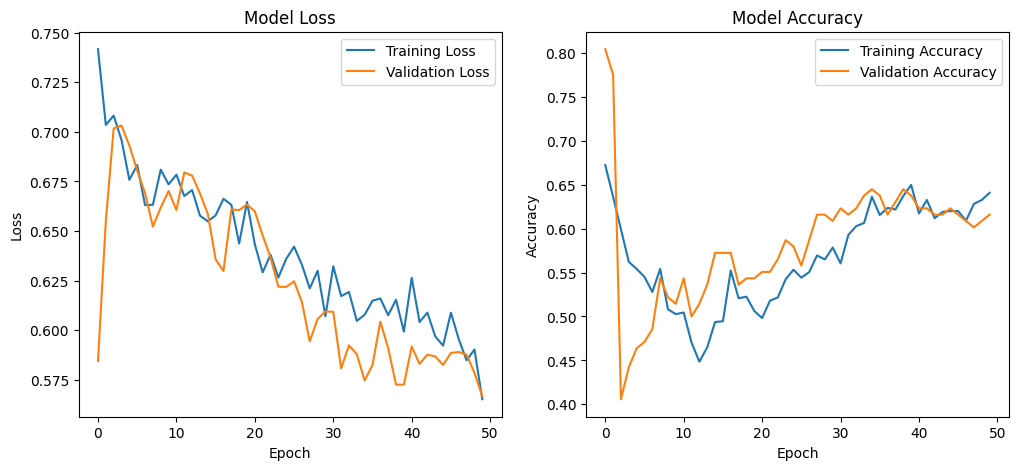

In [5]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[[0.63963964 0.36036036]
 [0.32142857 0.67857143]]
Precision:  0.6655507197857381


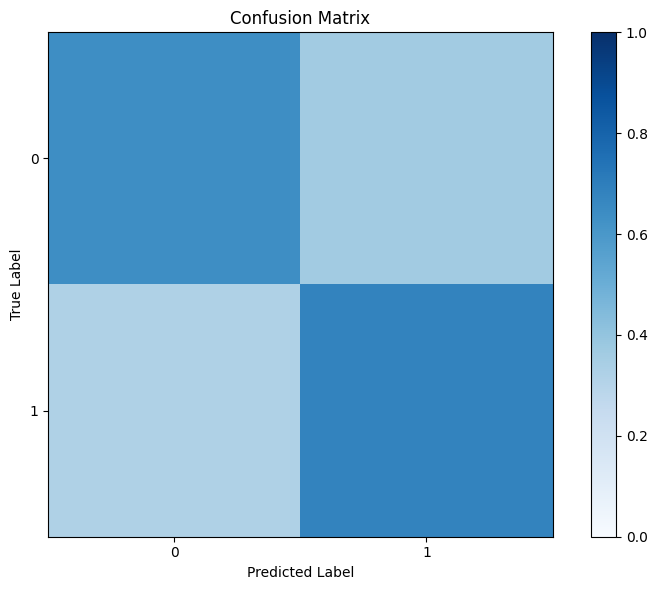

In [6]:
num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [80]:
conf_matrix_tabular[2]

array([[[0.53153153, 0.46846847],
        [0.25      , 0.75      ]],

       [[0.56756757, 0.43243243],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.17857143, 0.82142857]],

       [[0.7027027 , 0.2972973 ],
        [0.21428571, 0.78571429]],

       [[0.64864865, 0.35135135],
        [0.10714286, 0.89285714]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]],

       [[0.63963964, 0.36036036],
        [0.14285714, 0.85714286]],

       [[0.63063063, 0.36936937],
        [0.07142857, 0.92857143]],

       [[0.52252252, 0.47747748],
        [0.10714286, 0.89285714]],

       [[0.46846847, 0.53153153],
        [0.14285714, 0.85714286]],

       [[0.54954955, 0.45045045],
        [0.07142857, 0.92857143]]])

In [76]:
np.load('all_confusion_matrices_tabular.npy') # this is with seed 42

array([[[0.63063063, 0.36936937],
        [0.39285714, 0.60714286]],

       [[0.8018018 , 0.1981982 ],
        [0.39285714, 0.60714286]],

       [[0.65765766, 0.34234234],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.72972973, 0.27027027],
        [0.17857143, 0.82142857]],

       [[0.72072072, 0.27927928],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.10714286, 0.89285714]],

       [[0.63063063, 0.36936937],
        [0.17857143, 0.82142857]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]]])

In [63]:
conf_matrices_tabular.shape

(11, 2, 2)